# **Fourier spectoral solver for Cahn-Hilliard equation**
Total free energy
$$
G(c, \nabla c)=\int_V \left\{ f_{chem}(c)+f_{grad}(\nabla c) \right\}dV
$$
Chemical free energy density
$$
f_{chem}(c) = Ac^2(1-c)^2
$$
Gradient energy density
$$
f_{grad}(\nabla c) = \frac{a}{2}\left| \nabla c\ \right|^2
$$
Cahn-Hilliard equation assuming $M_c$ is constant. 
$$
\frac{\partial c}{\partial t} = \nabla \cdot \left( M_{c} \nabla \frac{\delta G}{\delta c} \right) =  M_{c}\nabla^2 \mu
$$
Total diffusion potential
$$
\mu = \frac{\delta G}{\delta c} = \frac{\partial f_{chem}}{\partial c} - a \nabla^{2}c 
$$
Chemital part of diffusion potential
$$
\frac{\partial f_{chem}}{\partial c} = 2Ac(1-c)^2-2Ac^2(1-c) = \mu_{chem}(c)
$$
Fourier transform and semi-implicit time integration
$$
\hat c_{t+1} = \hat  c_{t} - \Delta t M_{c}k^2 \hat{\mu}_{chem}(c_t) - \Delta t M_c a k^{4}\hat c_{t+1}
$$

Concentration at time $t+1$
$$
\hat c_{t+1}(1 + \Delta t M_ca k^{4}) = \hat  c_{t} - \Delta t M_{c}k^2 \hat{\mu}_{chem}(c_t)
$$

$$
\leftrightarrow \hat{c}_{t+1}=\frac{\hat{c}_{t}-\Delta tM k^2 \hat{\mu}_{chem}(c_t)}{1+\Delta t M a k^4}
$$

Inverse Fourier transform of concentration-field
$$
c_{t+1}=\mathcal{F}^{-1}(\hat c_{t+1})
$$

## **Import libraries**

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

## **Set parameters**

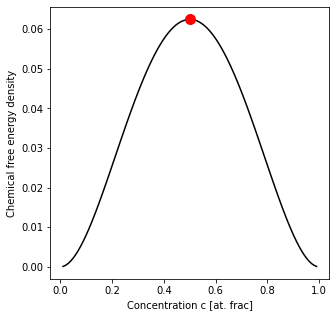

In [8]:
nx = ny = 256
dx = dy = 1.0
total_step = 1000
dt = 1.0e-2
A = 2.0
mobility = 1.0
grad_coef = 1.0
c0 = 0.5

fig = plt.figure(figsize=(5,5))
cc = np.linspace(0.01, 0.99, 100);
plt.plot(cc, cc**2*(1.-cc)**2 ,color='black')
plt.plot(c0, c0**2*(1.-c0)**2 ,color='r',marker='o',markersize=10)
plt.xlabel('Concentration c [at. frac]')
plt.ylabel('Chemical free energy density')
plt.show()

## **Malloc memory for arrays**

In [9]:
con = np.zeros([nx, ny]) # concentration of B atom
dfdcon = np.zeros([nx, ny]) # chemical part of diffusion potential

## **Initial random distribution of concentration-field**

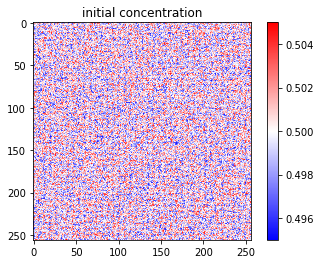

In [10]:
con = c0 + 0.01 * (0.5 - np.random.rand(nx, ny))

plt.imshow(con, cmap='bwr')
plt.title('initial concentration')
plt.colorbar()
plt.show() 

## **Define function to calculate Fourier ($k^2$) vector and calculate $k^4$**

In [11]:
def calc_wave_vector(nx, ny, dx, dy):
	nx21 = int(nx/2 + 1)
	ny21 = int(ny/2 + 1)
	nx2 = nx + 2
	ny2 = ny + 2
	dkx = (2.0 * np.pi) / (nx * dx)
	dky = (2.0 * np.pi) / (ny * dy)
	kx = np.zeros([nx, ny])
	ky = np.zeros([nx, ny])
	k2 = np.zeros([nx, ny])
	k4 = np.zeros([nx, ny])

	for i in range(1, nx21):
		for j in range(1, ny):
			fk1 = (i - 1) * dkx
			kx[i, :] = fk1
			kx[nx - i, :] = -fk1
	for i in range(1, nx):
		for j in range(1, ny21):
			fk2 = (j - 1) * dky
			ky[:, j] = fk2
			ky[:, ny - j] = -fk2

	k2[:, :] = kx[:, :]**2 + ky[:, :]**2
	return k2

k2 = calc_wave_vector(nx, ny, dx, dy)
k4 = k2 **2

## **Solve Cahn-Hilliard equation**


It takes  7277.677297592163 ms


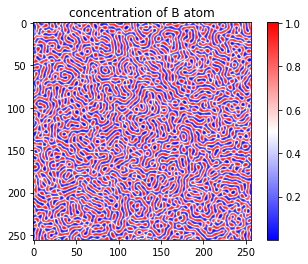

In [12]:
start = time()
for istep in range(total_step+1):
  conk = np.fft.fftn(con) # Fourier transform c_t
  dfdcon = (2.0 * con * (1 - con)**2 -2.0 * con**2 * (1 - con)) # Chemical part of diffusion potential
  dfdconk = np.fft.fftn(dfdcon)  # Fourier transform of the chemical part
  nummer = dt * mobility * A * k2 * dfdconk
  denom = 1.0 + dt * mobility * grad_coef * k4
  conk = (conk - nummer) / denom # Updated concentration c_t+dt in Fourier space
  con = np.real(np.fft.ifftn(conk)) # Inverse Fourier transform of c_t+dt

end = time()
print("It takes ", (end-start)*1000.0, "ms")

plt.imshow(con, cmap='bwr')
plt.title('concentration of B atom')
plt.colorbar()
plt.show()